In [17]:
%rm ../../kaggle -r

In [19]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATASETS
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE CELL.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote
from urllib.error import HTTPError
from zipfile import ZipFile

CHUNK_SIZE = 40960
DATASET_MAPPING = 'g-research-crypto-forecasting:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F30894%2F3114644%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20220122%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20220122T030101Z%26X-Goog-Expires%3D259199%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D81800f932d3f5ba0a654956a4c54303dc972817898a50ced9e64f56848dc5eaea8adb677be0422642c63e901105f13b3475ef7dc01359c2c010d1ee561ec9f936647e16677799fdc101f9bcf335401e3a4394b2db1c5e6f60f080b51ba1bd4bd263260507501e8f4c5b03fd227f3da15676e49556a90d100d270a36ff4b5ef45abe328843af71a934fe152767915357c4689c9f0c2ab71c09d7687a972f1f96c1576f2ad1bb920ce11fcdb6ef1aeb0e8470c805b5edec1cb0d51a80a85d4268ca84e7cdb0921ca42b7346cf918b60f6a250d9b85aaf9a4ed8e7b6e68c63db8d1f4fac217b27ee037a5ff86aa782085b03f99f54147a681efe232e7d1bb2468e5'
KAGGLE_INPUT_PATH='/home/kaggle/input'
KAGGLE_INPUT_SYMLINK='/kaggle'

# os.makedirs(KAGGLE_INPUT_PATH, 777)
# os.symlink(KAGGLE_INPUT_PATH, os.path.join('..', 'input'), target_is_directory=True)
# os.makedirs(KAGGLE_INPUT_SYMLINK)
# os.symlink(KAGGLE_INPUT_PATH, os.path.join(KAGGLE_INPUT_SYMLINK, 'input'), target_is_directory=True)

for dataset_mapping in DATASET_MAPPING.split(','):
    directory, download_url_encoded = dataset_mapping.split(':')
    download_url = unquote(download_url_encoded)
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as zipfileres, NamedTemporaryFile() as tfile:
            total_length = zipfileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes zipped')
            dl = 0
            data = zipfileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = zipfileres.read(CHUNK_SIZE)
            print(f'\nUnzipping {directory}')
            with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue
print('Dataset import complete.')


[==================================================] 1203401017 bytes downloaded
Unzipping g-research-crypto-forecasting
Dataset import complete.


In [1]:
import sys
sys.path.append('../input/g-research-crypto-forecasting/')
import gresearch_crypto

In [2]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype.name
        
        if col_type not in ['object', 'category', 'datetime64[ns, UTC]', 'datetime64[ns]']:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

# 1. Target reconstruction - quick summary of SOTA

This notebook summarises community contributions, many found in and around [alexfir's notebook](https://www.kaggle.com/alexfir/recreating-target) - upvote there if these insights help you in this competition!

## Reconstruction statistics for the train set:

* Mean abs error: 0.00000000000000082
* Max abs error:  0.00000000000000276
* Std abs error:  0.00000000000008532


In [3]:
import os
import gc
import numpy as np
import pandas as pd

data_path = '../input/g-research-crypto-forecasting/train.csv'
dtypes = {
    'timestamp': np.int64,
    'Asset_ID': np.int8,
    'Count': np.float32,
    'Open': np.float32,
    'High': np.float32,
    'Low': np.float32,
    'Close': np.float32,
    'Volume': np.float32,
    'VWAP': np.float32,
    'Target': np.float32
}
train = pd.read_csv(data_path, dtype=dtypes, usecols=list(dtypes.keys()))

asset_details_path = '../input/g-research-crypto-forecasting/asset_details.csv'
asset_details = pd.read_csv(asset_details_path)
assets_order = dict((t,i) for i,t in enumerate(asset_details.Asset_ID))

# crypto_df = train.merge(asset_details, on='Asset_ID')
# crypto_df['timestamp'] = pd.to_datetime(crypto_df['timestamp'], unit='s')

In [18]:
# essentially verbatim from https://www.kaggle.com/alexfir/recreating-target/
def reconstruct_targets(data: pd.DataFrame, details: pd.DataFrame, price_column: str, use_log=False):
    
    ids = list(details.Asset_ID)
    asset_names = list(details.Asset_Name)
    weights = np.array(list(details.Weight))

    all_timestamps = np.sort(data.time_idx.unique())

    targets = pd.DataFrame(index=all_timestamps)

    for i, id in enumerate(ids):
        asset = data[data.Asset_ID == id].set_index(keys='time_idx')
        price = pd.Series(index=all_timestamps, data=asset[price_column])
        if use_log:
            targets[asset_names[i]] = np.log(price.shift(periods=-16)) - np.log(price.shift(periods=-1))
        else:
            targets[asset_names[i]] = (
                price.shift(periods=-16) /
                price.shift(periods=-1)
            ) - 1
            
    targets['m'] = np.average(targets.fillna(0), axis=1, weights=weights)
    m = targets['m']
    
    num = targets.multiply(m.values, axis=0).rolling(3750).mean().values
    denom = m.multiply(m.values, axis=0).rolling(3750).mean().values
    beta = np.nan_to_num(num.T / denom, nan=0., posinf=0., neginf=0.)
    
    recon_targets = targets - (beta * m.values).T
    recon_targets.drop('m', axis=1, inplace=True)
    
    return recon_targets

In [19]:
def merge_recon_with_train():
    recon_targets = reconstruct_targets(data=crypto_df, details=asset_details, price_column='Close')
    recon_targets = pd.melt(recon_targets.reset_index(), id_vars='index')
    recon_targets = recon_targets.rename(columns={'index':'time_idx', 'variable':'Asset_Name', 'value':'recon_Target'})
    crypto_df = crypto_df.merge(asset_details, on='Asset_ID')
    return crypto_df.merge(recon_targets, on=['Asset_Name', 'time_idx'])

In [20]:
def merge_recon_with_test(crypto_df, asset_details, price_column='Close'):
    recon_targets = reconstruct_targets(data=crypto_df, details=asset_details, price_column=price_column)
    recon_targets = pd.melt(recon_targets.reset_index(), id_vars='index')
    recon_targets = recon_targets.rename(columns={'index':'time_idx', 'variable':'Asset_Name', 'value':'Target'})
    crypto_df = crypto_df.merge(asset_details, on='Asset_ID')
    return crypto_df.merge(recon_targets, on=['Asset_Name', 'time_idx'])

In [5]:
df = merge_recon_with_train()

print("Is it true that all NaN's match between Target and recon_Target?")
print(f"{all(df.Target.isna() == df.recon_Target.isna())}\n")

print("Is it true that none of the Targets have been dropped?")
print(f"{len(crypto_df.Target)==len(df.Target)}\n")

print("Statistics for absolute error between Target and reconstructed Target for the entirety of train data:")
abserror = abs(df['Target'] - df['recon_Target'])
print(abserror.describe())

Is it true that all NaN's match between Target and recon_Target?
True

Is it true that none of the Targets have been dropped?
True

Statistics for absolute error between Target and reconstructed Target for the entirety of train data:
count    2.348647e+07
mean     8.199023e-16
std      2.755327e-15
min      0.000000e+00
25%      6.288373e-17
50%      1.987343e-16
75%      6.908536e-16
max      8.532064e-14
dtype: float64


# 2. Preparing Train Dataset

Credit: [N-BEATS Baseline Notebook](https://www.kaggle.com/yamqwe/n-beats-baseline-notebook?scriptVersionId=82240910)

In [4]:
train.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.580078,2399.500000,2357.139893,2374.590088,19.233006,2373.116455,-0.004218
1,1514764860,0,5.0,8.530000,8.530000,8.530000,8.530000,78.379997,8.530000,-0.014399
2,1514764860,1,229.0,13835.194336,14013.799805,13666.110352,13850.175781,31.550062,13827.062500,-0.014643
3,1514764860,5,32.0,7.659600,7.659600,7.656700,7.657600,6626.713379,7.657713,-0.013922
4,1514764860,7,5.0,25.920000,25.920000,25.874001,25.877001,121.087311,25.891363,-0.008264


In [5]:
print(train.shape)
train['Target'] = train['Target'].fillna(0)
VWAP_max = np.max(train[np.isfinite(train.VWAP)].VWAP)
VWAP_min = np.min(train[np.isfinite(train.VWAP)].VWAP)
train['VWAP'] = np.nan_to_num(train.VWAP, posinf=VWAP_max, neginf=VWAP_min)
df = train[['Asset_ID', 'Target']].copy()
times = dict((t,i) for i,t in enumerate(df.index.unique()))
df['id'] = df.index.map(times)
df['id'] = df['id'].astype(str) + '_' + df['Asset_ID'].astype(str)
ids = df.id.copy()
del df

(24236806, 10)


IOStream.flush timed out


In [6]:
train = train.sort_index()
ind = train.index.unique()
def reindex(df):
    df = df.reindex(range(ind[0],ind[-1]+60,60),method='nearest')
    df = df.fillna(method="ffill").fillna(method="bfill")
    return df
train = train.groupby('Asset_ID').apply(reindex).reset_index(0, drop=True).sort_index()
gc.collect()
train.shape

(5655272, 10)

In [7]:
# Matching records and marking generated rows as 'non-real'
train['group_num'] = train.index.map(times)
train = train.dropna(subset=['group_num'])
train['group_num'] = train['group_num'].astype('int')
train['id'] = train['group_num'].astype(str) + '_' + train['Asset_ID'].astype(str)
train['is_real'] = train.id.isin(ids) * 1
train = train.drop('id', axis=1)

In [8]:
# Features values for 'non-real' rows are set to zeros
# features = train.columns.drop(['Asset_ID','group_num','is_real'])
# train.loc[train.is_real == 0, features] = 0.

In [9]:
train['asset_order'] = train.Asset_ID.map(assets_order)
train = train.sort_values(by=['group_num', 'asset_order'])
train = reduce_mem_usage(train)
gc.collect()

Memory usage of dataframe is 393.71 MB
Memory usage after optimization is: 226.52 MB
Decreased by 42.5%


0

In [10]:
# train = train[train.is_real == True]
train.head(20)

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,group_num,is_real,asset_order
0,1514764860,2,40.0,2376.000000,2400.000000,2358.000000,2374.000000,19.233006,2374.000000,-0.004219,0,1,0
0,1514764860,0,5.0,8.531250,8.531250,8.531250,8.531250,78.379997,8.531250,-0.014397,0,0,1
0,1514764860,1,229.0,13832.000000,14016.000000,13664.000000,13848.000000,31.550062,13824.000000,-0.014641,0,0,2
0,1514764860,5,32.0,7.660156,7.660156,7.656250,7.656250,6626.713379,7.656250,-0.013924,0,0,3
0,1514764860,7,5.0,25.921875,25.921875,25.875000,25.875000,121.087311,25.890625,-0.008263,0,0,4
0,1514764860,6,173.0,738.500000,746.000000,732.500000,738.500000,335.987854,739.000000,-0.004810,0,0,5
0,1514764860,9,167.0,225.375000,227.750000,223.000000,225.250000,411.896637,225.250000,-0.009789,0,0,6
0,1514764860,11,7.0,329.000000,330.000000,329.000000,329.500000,6.635710,329.500000,0.000000,0,0,7
0,1517953020,13,8.0,0.036987,0.036987,0.036591,0.036743,83459.109375,0.036591,-0.016205,0,0,8
0,1518825180,12,4.0,0.409912,0.409912,0.360107,0.360107,3779.363037,0.405273,0.000000,0,0,9


# 3. Nbeats Baseline

Following this tutorial: [Interpretable forecasting with N-Beats](https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/ar.html)

In [59]:
%pip install pytorch-forecasting

     |████████████████████████████████| 113 kB 4.0 MB/s            
     |████████████████████████████████| 24.8 MB 16.6 MB/s            
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.19.0 requires statsmodels>=0.13, but you have statsmodels 0.12.2 which is incompatible.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.5.1 which is incompatible.
hypertools 0.7.0 requires scikit-learn!=0.22,<0.24,>=0.19.1, but you have scikit-learn 1.0.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [11]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torch

from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, EncoderNormalizer
from sklearn.preprocessing import RobustScaler
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.metrics import SMAPE, RMSE

## 3.1 Load Data

In [12]:
# one day of 1 minute intervals
max_encoder_length = 180
# 15 minutes so we can recreate the target
max_prediction_length = 17

train['time_idx'] = [int(i) for i in train.group_num / 60]
train = train.sort_values(['Asset_ID','time_idx']).reset_index(drop=True)
training_cutoff = train["time_idx"].max() - max_prediction_length
# training_cutoff = train.groupby('Asset_ID').max()[["time_idx"]] - max_prediction_length
# train = train.join(training_cutoff,on='Asset_ID',rsuffix="_cutoff")

In [206]:
# create dataset and dataloaders
context_length = max_encoder_length
prediction_length = max_prediction_length
norm = GroupNormalizer(groups=['Asset_ID'],center=False)#,transformation="relu")

training = TimeSeriesDataSet(
    train[lambda f: f.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Close",
    categorical_encoders={"Asset_ID": NaNLabelEncoder().fit(train.Asset_ID)},
    group_ids=["Asset_ID"],
    # only unknown variable is "value" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["Close"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
    # target_normalizer=norm,
    # allow_missing_timesteps=True,
)

validation = TimeSeriesDataSet.from_dataset(training, train, min_prediction_idx=training_cutoff + 1)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:192: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


## 3.2 Calculate baseline error

In [207]:
# calculate baseline absolute error
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
SMAPE()(baseline_predictions, actuals)

tensor(0.0188)

## 3.3 Train Network

In [208]:
pl.seed_everything(42)
trainer = pl.Trainer(gpus=1, gradient_clip_val=0.01)
net = NBeats.from_dataset(training, learning_rate=3e-3, weight_decay=1e-2, widths=[32, 512], backcast_loss_ratio=0.1)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1076: LightningDeprecationWarning: `trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
  "`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of th

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

suggested learning rate: 5.0118723362727245e-05


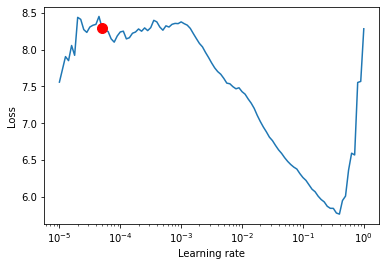

In [209]:
# find optimal learning rate
res = trainer.tuner.lr_find(net, train_dataloader=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [210]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=20, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=200,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.01,
    callbacks=[early_stop_callback],
    limit_train_batches=30,
)


net = NBeats.from_dataset(
    training,
    learning_rate=8e-03,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    widths=[32, 512],
    backcast_loss_ratio=1.0,
)

trainer.fit(
    net,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:734: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  "`trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6."


Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:413: UserWarning: The number of training samples (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,


Validating: 0it [00:00, ?it/s]

## 3.4 Evaluate Results

In [13]:
best_model_path = '/home/jupyter/imported/lightning_logs/version_9/checkpoints/epoch=20-step=629.ckpt'#trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

In [212]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
SMAPE()(predictions, actuals)

tensor(0.0227)

In [213]:
raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)

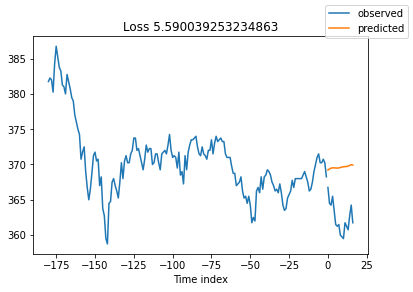

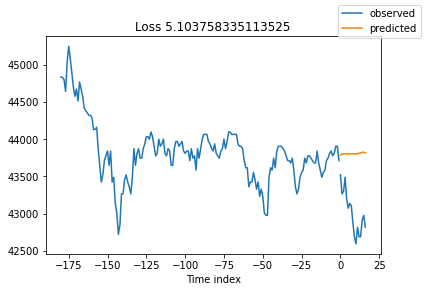

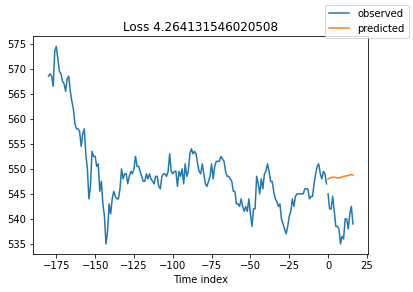

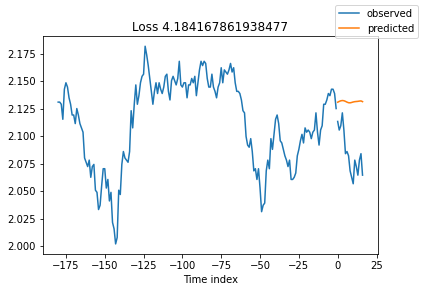

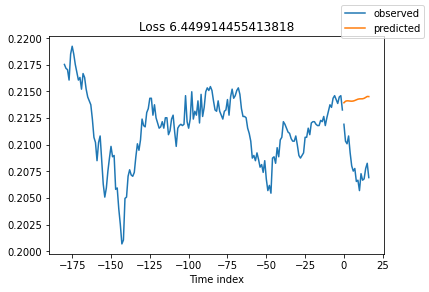

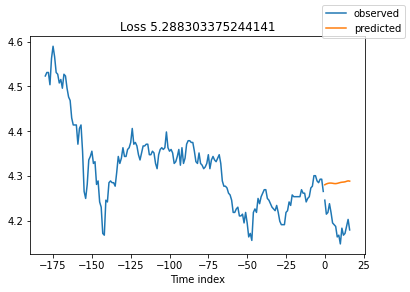

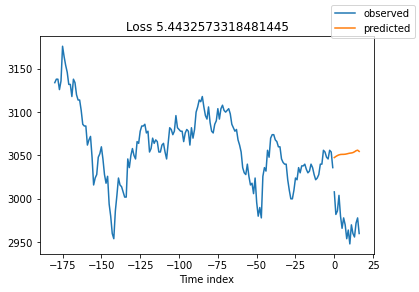

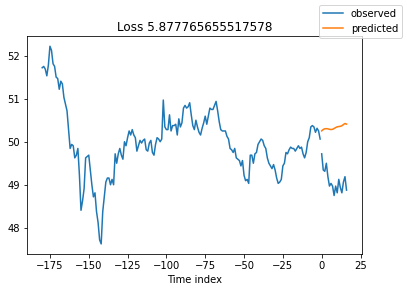

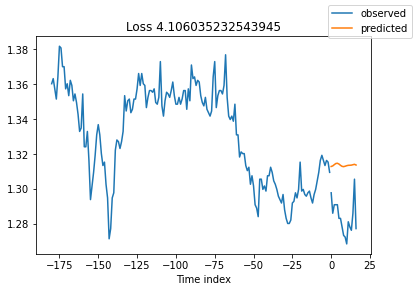

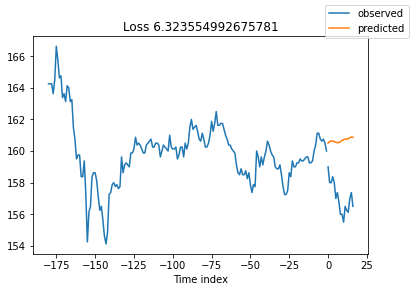

In [214]:
for idx in range(10):  # plot 10 examples
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

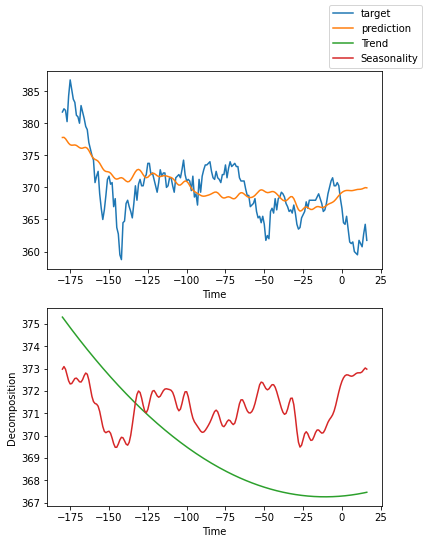

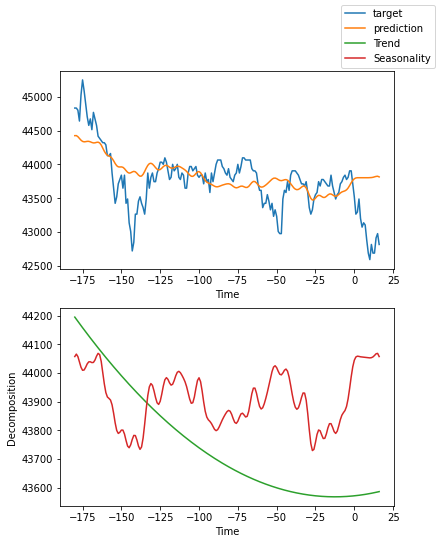

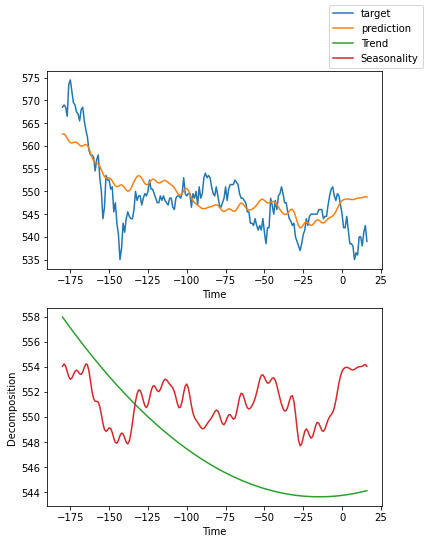

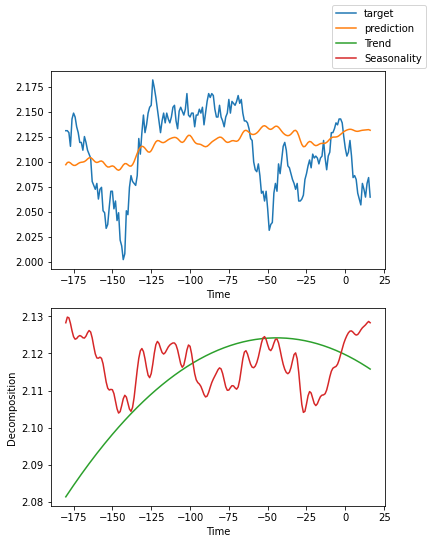

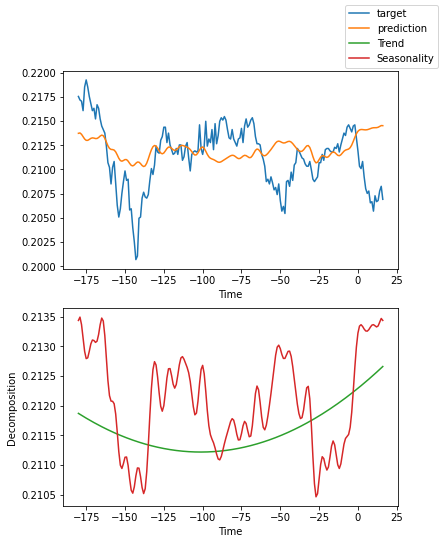

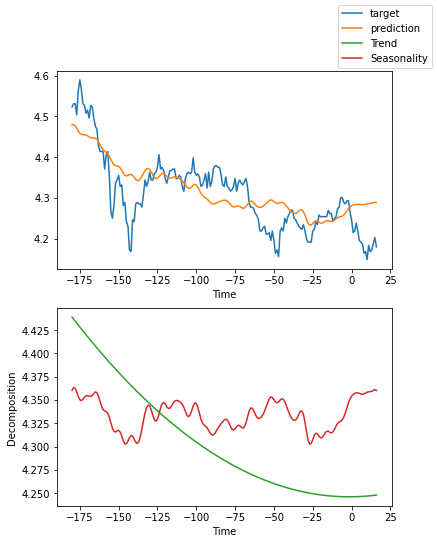

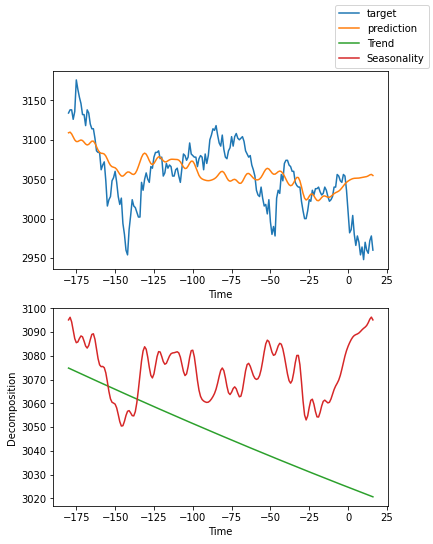

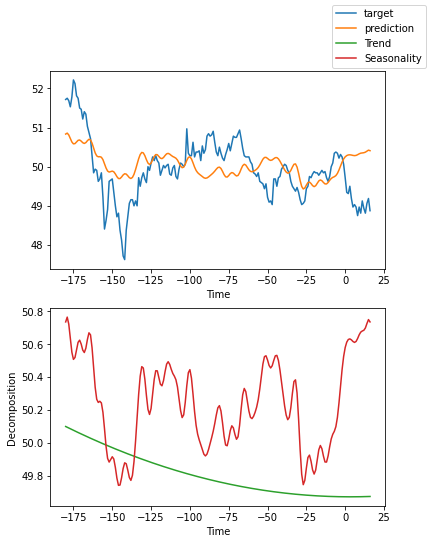

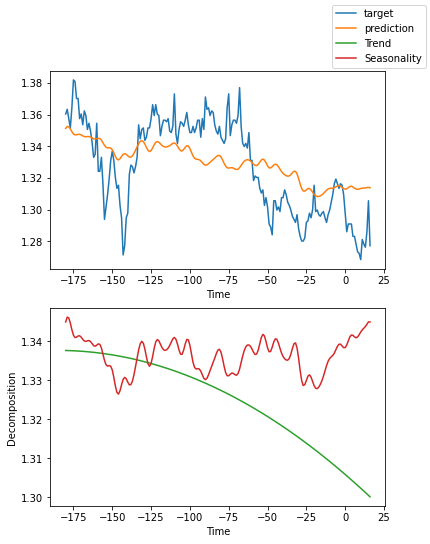

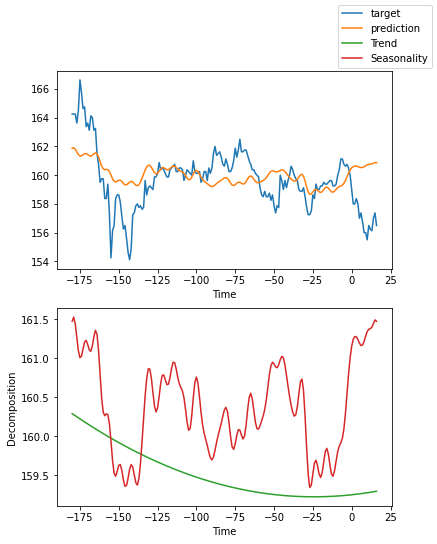

In [215]:
for idx in range(10):  # plot 10 examples
    best_model.plot_interpretation(x, raw_predictions, idx=idx);

# 4. Making a submission


In [14]:
env = gresearch_crypto.make_env()

In [16]:
iter_test = env.iter_test()

In [23]:
(test_df, sample_prediction_df) = next(iter_test)
test_df.head(3)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,row_id
0,1623542400,3,1201,1.478556,1.48603,1.478,1.483681,654799.561103,1.481439,0
1,1623542400,2,1020,580.306667,583.89000,579.910,582.276667,1227.988328,581.697038,1
2,1623542400,0,626,343.789500,345.10800,343.640,344.598000,1718.832569,344.441729,2


In [241]:
sample_prediction_df

,row_id,Target
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0
5,5,0.0
6,6,0.0
7,7,0.0
8,8,0.0
9,9,0.0


In [20]:
next(iter_test)

You must call `predict()` successfully before you can continue with `iter_test()`


In [216]:
cutoff = test_df.timestamp[0]

In [217]:
ts_df = train[train['timestamp']<cutoff]

In [218]:
encoder = ts_df.sort_values('timestamp').groupby('Asset_ID').tail(max_encoder_length)
encoder = encoder[['time_idx','Asset_ID','Close']]
encoder_idx = max(encoder.time_idx)+1

In [219]:
test_df['time_idx'] = encoder_idx

In [220]:
encoder = pd.concat([encoder,test_df[['time_idx','Asset_ID','Close']]],ignore_index=True)

In [221]:
encoder = pd.concat([encoder,
           pd.DataFrame([[encoder_idx+i+1,asset,0] 
                         for asset in test_df.Asset_ID 
                         for i in range(max_prediction_length-1)], 
                        columns=['time_idx','Asset_ID','Close'])],ignore_index=True)
encoder

,time_idx,Asset_ID,Close
0,370182,12,0.318604
1,370182,11,248.250000
2,370182,10,2938.000000
3,370182,13,0.067993
4,370182,9,159.875000
...,...,...,...
2753,370374,11,0.000000
2754,370375,11,0.000000
2755,370376,11,0.000000
2756,370377,11,0.000000


In [224]:
preds, idx = best_model.predict(encoder,return_index=True)

asset_id = []
for x in idx['Asset_ID']:
    for j in range(max_prediction_length):
        asset_id.append(x)
        
pred_df = pd.DataFrame(zip(
    [j for i in idx['time_idx'] for j in range(i,i+max_prediction_length)],
    asset_id,
    [float(q) for p in preds for q in p]
)).rename(columns={0:'time_idx',1:'Asset_ID',2:'Close'})

In [231]:
# pred_df['timestamp'] = test_df['timestamp'][0] + (pred_df['time_idx'] - encoder_idx) * 60
# pred_df

,time_idx,Asset_ID,Close,timestamp
0,370362,0,344.040405,1623542400
1,370363,0,344.047913,1623542460
2,370364,0,344.066315,1623542520
3,370365,0,344.079132,1623542580
4,370366,0,344.088654,1623542640
...,...,...,...,...
233,370374,13,0.068192,1623543120
234,370375,13,0.068195,1623543180
235,370376,13,0.068198,1623543240
236,370377,13,0.068200,1623543300


In [225]:
ts_df = pd.concat([ts_df[['time_idx','Asset_ID','Close']],pred_df], ignore_index=True)

In [238]:
ts_df[ts_df['time_idx']==encoder_idx]

,time_idx,Asset_ID,Close
5185068,370362,0,344.040405
5185085,370362,1,35530.597656
5185102,370362,2,580.888855
5185119,370362,3,1.479579
5185136,370362,4,0.312315
5185153,370362,5,4.834798
5185170,370362,6,2376.477051
5185187,370362,7,55.319756
5185204,370362,8,1.002298
5185221,370362,9,162.030334


In [229]:
df = merge_recon_with_test(crypto_df=ts_df.sort_values('time_idx', ascending=False).groupby('Asset_ID').head(5000), asset_details=asset_details)

In [246]:
predictions_df = df[df['time_idx']==encoder_idx]\
    .set_index('Asset_ID')\
    .join(test_df.set_index('Asset_ID')['row_id'])\
    .sort_values('row_id')\
    .reset_index(drop=True)[['row_id','Target']]

In [247]:
env.predict(predictions_df)

In [259]:
ts_df = train.copy()

In [22]:
train

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,group_num,is_real,asset_order,time_idx
0,1514764860,0,5.0,8.531250,8.531250,8.531250,8.531250,7.838000e+01,8.531250,-0.014397,0,0,1,0
1,1514765280,0,25.0,8.382812,8.453125,8.382812,8.382812,3.700400e+02,8.390625,-0.003580,60,0,1,1
2,1514765760,0,50.0,8.429688,8.429688,8.398438,8.398438,1.069650e+03,8.398438,-0.002289,120,1,1,2
3,1514766240,0,52.0,8.375000,8.375000,8.351562,8.351562,2.369950e+03,8.351562,-0.003319,180,0,1,3
4,1514766720,0,13.0,8.351562,8.375000,8.351562,8.375000,7.866300e+02,8.351562,0.003246,240,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5655253,1632181200,13,986.0,0.090881,0.091064,0.090698,0.090942,5.734456e+06,0.090820,0.000199,24236520,0,8,403942
5655254,1632181440,13,512.0,0.091003,0.091125,0.090820,0.090881,1.900696e+06,0.090942,0.004162,24236580,0,8,403943
5655255,1632181680,13,422.0,0.091125,0.091187,0.090942,0.091003,1.707701e+06,0.091064,0.000000,24236640,0,8,403944
5655256,1632181980,13,386.0,0.091553,0.091614,0.091431,0.091553,1.550128e+06,0.091553,0.000000,24236700,0,8,403945


In [26]:
ts_df = train.copy()

for (test_df, sample_prediction_df) in iter_test:
    cutoff = test_df.timestamp[0]
    ts_df = ts_df[ts_df['timestamp']<cutoff]
    
    encoder = ts_df.sort_values('timestamp').groupby('Asset_ID').tail(max_encoder_length)
    encoder = encoder[['time_idx','Asset_ID','Close']]
    encoder_idx = max(encoder.time_idx)+1
    
    test_df['time_idx'] = encoder_idx
    
    encoder = pd.concat([encoder,test_df[['time_idx','Asset_ID','Close']]],ignore_index=True)
    encoder = pd.concat([encoder,
               pd.DataFrame([[encoder_idx+i+1,asset,0] 
                             for asset in test_df.Asset_ID 
                             for i in range(max_prediction_length-1)], 
                            columns=['time_idx','Asset_ID','Close'])],ignore_index=True)
    
    preds, idx = best_model.predict(encoder,return_index=True)

    asset_id = []
    for x in idx['Asset_ID']:
        for j in range(max_prediction_length):
            asset_id.append(x)

    pred_df = pd.DataFrame(zip(
        [j for i in idx['time_idx'] for j in range(i,i+max_prediction_length)],
        asset_id,
        [float(q) for p in preds for q in p]
    )).rename(columns={0:'time_idx',1:'Asset_ID',2:'Close'})
    
    pred_df['timestamp'] = test_df['timestamp'][0] + (pred_df['time_idx'] - encoder_idx) * 60
    
    ts_df = pd.concat([ts_df[['time_idx','timestamp','Asset_ID','Close']],pred_df], ignore_index=True)
    
    df = merge_recon_with_test(crypto_df=ts_df.sort_values('time_idx', ascending=False)\
                               .groupby('Asset_ID').head(5000), asset_details=asset_details)
    
    predictions_df = df[df['time_idx']==encoder_idx]\
        .set_index('Asset_ID')\
        .join(test_df.set_index('Asset_ID')['row_id'])\
        .sort_values('row_id')\
        .reset_index(drop=True)[['row_id','Target']]
    
    env.predict(predictions_df)

In [24]:
ts_df = train.copy()

In [25]:
cutoff = test_df.timestamp[0]
ts_df = ts_df[ts_df['timestamp']<cutoff]

encoder = ts_df.sort_values('timestamp').groupby('Asset_ID').tail(max_encoder_length)
encoder = encoder[['time_idx','Asset_ID','Close']]
encoder_idx = max(encoder.time_idx)+1

test_df['time_idx'] = encoder_idx

encoder = pd.concat([encoder,test_df[['time_idx','Asset_ID','Close']]],ignore_index=True)
encoder = pd.concat([encoder,
           pd.DataFrame([[encoder_idx+i+1,asset,0] 
                         for asset in test_df.Asset_ID 
                         for i in range(max_prediction_length-1)], 
                        columns=['time_idx','Asset_ID','Close'])],ignore_index=True)

preds, idx = best_model.predict(encoder,return_index=True)

asset_id = []
for x in idx['Asset_ID']:
    for j in range(max_prediction_length):
        asset_id.append(x)

pred_df = pd.DataFrame(zip(
    [j for i in idx['time_idx'] for j in range(i,i+max_prediction_length)],
    asset_id,
    [float(q) for p in preds for q in p]
)).rename(columns={0:'time_idx',1:'Asset_ID',2:'Close'})

pred_df['timestamp'] = test_df['timestamp'][0] + (pred_df['time_idx'] - encoder_idx) * 60

ts_df = pd.concat([ts_df[['time_idx','timestamp','Asset_ID','Close']],pred_df], ignore_index=True)

df = merge_recon_with_test(crypto_df=ts_df.sort_values('time_idx', ascending=False)\
                           .groupby('Asset_ID').head(5000), asset_details=asset_details)

predictions_df = df[df['time_idx']==encoder_idx]\
    .set_index('Asset_ID')\
    .join(test_df.set_index('Asset_ID')['row_id'])\
    .sort_values('row_id')\
    .reset_index(drop=True)[['row_id','Target']]

env.predict(predictions_df)

In [264]:
ts_df = ts_df[ts_df['timestamp']<cutoff]

encoder = ts_df.sort_values('timestamp').groupby('Asset_ID').tail(max_encoder_length)
encoder = encoder[['time_idx','Asset_ID','Close']]
encoder_idx = max(encoder.time_idx)+1

test_df['time_idx'] = encoder_idx

encoder = pd.concat([encoder,test_df[['time_idx','Asset_ID','Close']]],ignore_index=True)
encoder = pd.concat([encoder,
           pd.DataFrame([[encoder_idx+i+1,asset,0] 
                         for asset in test_df.Asset_ID 
                         for i in range(max_prediction_length-1)], 
                        columns=['time_idx','Asset_ID','Close'])],ignore_index=True)

In [277]:
encoder_idx

370363

In [276]:
list(encoder[encoder['Asset_ID']==0].time_idx)

[370182,
 370183,
 370184,
 370185,
 370186,
 370187,
 370188,
 370189,
 370190,
 370191,
 370192,
 370193,
 370194,
 370195,
 370196,
 370197,
 370198,
 370199,
 370200,
 370201,
 370202,
 370203,
 370204,
 370205,
 370206,
 370207,
 370208,
 370209,
 370210,
 370211,
 370212,
 370213,
 370214,
 370215,
 370216,
 370217,
 370218,
 370219,
 370220,
 370221,
 370222,
 370223,
 370224,
 370225,
 370226,
 370227,
 370228,
 370229,
 370230,
 370231,
 370232,
 370233,
 370234,
 370235,
 370236,
 370237,
 370238,
 370239,
 370240,
 370241,
 370242,
 370243,
 370244,
 370245,
 370246,
 370247,
 370248,
 370249,
 370250,
 370251,
 370252,
 370253,
 370254,
 370255,
 370256,
 370257,
 370258,
 370259,
 370260,
 370261,
 370262,
 370263,
 370264,
 370265,
 370266,
 370267,
 370268,
 370269,
 370270,
 370271,
 370272,
 370273,
 370274,
 370275,
 370276,
 370277,
 370278,
 370279,
 370280,
 370281,
 370282,
 370283,
 370284,
 370285,
 370286,
 370287,
 370288,
 370289,
 370290,
 370291,
 370292,
 

In [272]:
max(encoder.time_idx)

370379

In [271]:
encoder.time_idx.min()

370182

In [266]:
preds, idx = best_model.predict(encoder,return_index=True)

AssertionError: Time difference between steps has been idenfied as larger than 1 - set allow_missing_timesteps=True